# BPL_CHO_Fedbatch - demo

This notebook deals with CHO fedbatch cultivation and recombinant protein production is included. We look first at start-up strategy to keep the by-product formation low. After that we look at a whole cultivation and see the impact of feeding strategy on both cell growth and protein production where a trade-off is needed in this case. 

The model used takes its inspiration from the microbial bottleneck models [1]. The original model is here expanded with the classical empirical Luedeking-Piret model recombinant protein production. 

Interaction with the compiled model as FMU is mainly through the simplified commands: par(), init(), newplot(), simu() etc. The last simulation is always available in the workspace and called 'sim_res'. The command describe() brings mainly up description infomration from the actual Modelica code from the FMU but is complemented with information given in the dedicated Python setup-file.

The idea is to demonstrate how simulations and varyiing conditions can provide some process insight that can support the experimetnal work. I hope that at the end of this session you are ready to formulate your own questions you want to address with simulations - and you can just go on in this notebook! Just press the field "+Code" in the upper left part of notebook interface and you get a new "cell" where you write your own code. You can copy and paste from cells above using ctrol-c and ctrl-p as usual and edit the cell. When your are ready to execute the cell just press the "play button" to the left in the cell or press shift-enter as in "ordinary" Jupyter notebooks.

After a session you may want to save your own notebook. That you can do on your Google Drive account and I refer to Colab instructions for how to do this. It is easy.

Good luck!

In [1]:
run -i BPL_CHO_fedbatch_explore.py

Windows - run FMU pre-compiled JModelica 2.14

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values / units

Note that both disp() and describe() takes values from the last simulation

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
plt.rcParams['figure.figsize'] = [30/2.54, 24/2.54]

## About the process model

We can get information about the process and liquid phase by the command describe(). Here is no gas-phase included. This command can also be used to bring up information about a specific variable or parameter. However, you should use describe() after a simulation to get the valued used during the simulation.

In [3]:
describe('culture'); print(); describe('liquidphase')

Reactor culture CHO-MAb - cell line HB-58 American Culture Collection ATCC

Reactor broth substances included in the model

Cells viable index =  1 molecular weight =  24.6 Da
Cells dead   index =  2 molecular weight =  24.6 Da
Glucose      index =  3 molecular weight =  180.0 Da
Glutamine    index =  4 molecular weight =  146.1 Da
Lactate      index =  5 molecular weight =  90.1 Da
Ammonia      index =  6 molecular weight =  17.0 Da
Protein      index =  7 molecular weight =  150000.0 Da


## Simulation reproducing the original paper

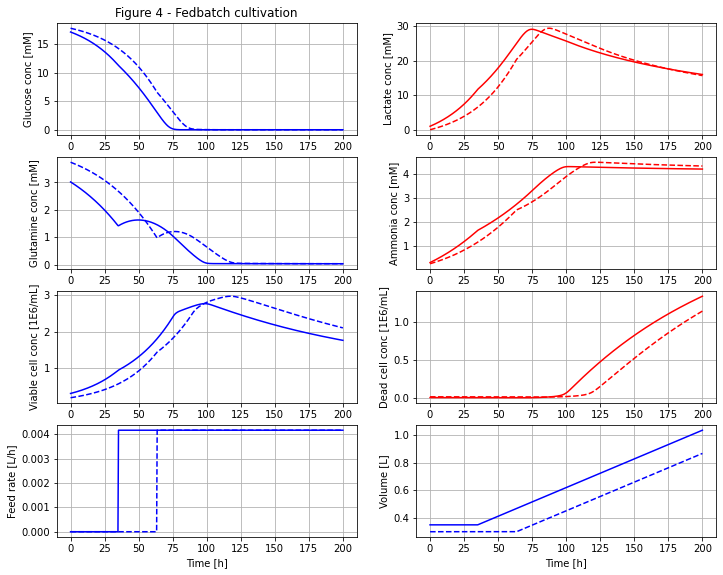

In [4]:
# Data from Table 1 and 2 for experiment 3
V_0=0.35
init(V_0=V_0, VXv_0=V_0*0.29, VXd_0=V_0*0.010) 
init(VG_0=V_0*17.17, VGn_0=V_0*3.02, VL_0=V_0*1.12, VN_0=V_0*0.29)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=35, F1=Feed, t2=300, F2=Feed)

# Culture parameters taken from Table 5 identified parameters for cultures 1,2,and 3

# Simulation
newplot(title='Figure 4 - Fedbatch cultivation') 
simu(200)

# Figur 5
V_0=0.30
init(V_0=V_0, VXv_0=V_0*0.172, VXd_0=V_0*0.020) 
init(VG_0=V_0*17.83, VGn_0=V_0*3.74, VL_0=V_0*0.12, VN_0=V_0*0.24)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=63.5, F1=Feed, t2=300, F2=Feed)
simu(200)


## Simulation of different start-up feeding strategies

In [5]:
DeltaVG = 15*0.1*0.4
print(DeltaVG)

0.6000000000000001


In [6]:
DeltaVG_0=(1-0.4)*0.30*17.8
print(DeltaVG_0)

3.204


In [7]:
describe('bioreactor.inlet[1].F')

Flow rate : 0.004 [ L/h ]


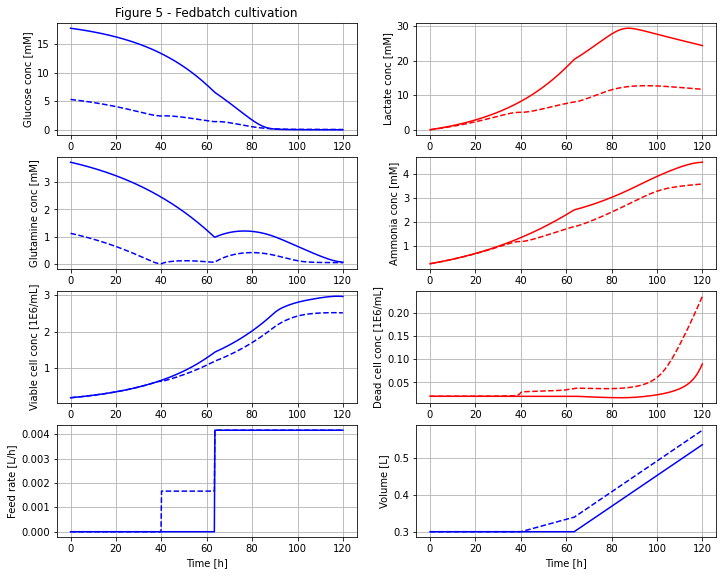

In [8]:
# Figur 5
V_0=0.30
init(V_0=V_0, VXv_0=V_0*0.172, VXd_0=V_0*0.020) 
init(VG_0=V_0*17.83, VGn_0=V_0*3.74, VL_0=V_0*0.12, VN_0=V_0*0.24)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=63.5, F1=Feed, t2=300, F2=Feed)

newplot(title='Figure 5 - Fedbatch cultivation') 
simu(120)

init(VG_0=0.3*V_0*17.83, VGn_0=0.3*V_0*3.74)
par(t0=0, F0=0, t1=40.0, F1=0.4*Feed, t2=63.5, F2=Feed,t3=300, F3=Feed)
simu(120)


## Simulation of recombinant protein production during the whole process

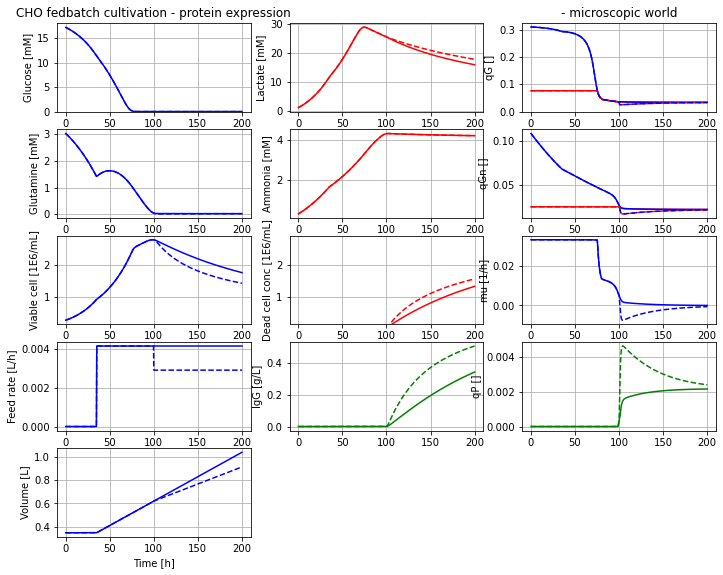

In [9]:
# Slide 3
newplot('CHO fedbatch cultivation - protein expression', plotType='Textbook_3')

# Data from Table 1 and 2 for experiment 3
V_0=0.35
init(V_0=V_0, VXv_0=V_0*0.29, VXd_0=V_0*0.010)
init(VG_0=V_0*17.17, VGn_0=V_0*3.02, VL_0=V_0*1.12, VN_0=V_0*0.29)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=35, F1=Feed, t2=100, F2=Feed, t3=300, F3=Feed)

# Culture parameters
par(alpha=-1.0, beta=0.01)

# Simulation
simu(200)
par(t2=100, F2=0.7*Feed, t3=300, F3=0.7*Feed); simu(200)
par(F2=Feed, F3=Feed)

## Summary

## References

[1] Amribt, Z., Niu, H. and Bogaerts P.: "Macroscopic modelling of overflow metabolism and model based optimization of hybridoma cell fed-batch cultures.", Biochem. Eng. Journal, 2013.

[2] Niu,H., Amribt, Z., Fickers, P., Tan, W. and Bogaerts P.: "Metabolic pathway analysis and reduction for mammalian cell cultures - towards macroscopic modelling", Chem. Eng. Science, 2013.

[3] Axelsson, J. P. "Simplified model of CHO-cultivation in Bioproces Library for Modelica - some experience", conference paper 22nd NPCW Lyngby, Denmark, August 22-23, 2019.

## Appendix

In [10]:
# List of components in the process setup and also a couple of other things like liquidphase and gasphase etc
describe('parts')

['bioreactor', 'bioreactor.broth_decay', 'bioreactor.culture', 'dosagescheme', 'feedtank', 'liquidphase', 'MSL']


In [11]:
describe('MSL')

MSL: 3.2.2 build 3 - used components: RealInput, RealOutput, CombiTimeTable, Types


In [12]:
system_info()


System information
 -OS: Windows
 -Python: 3.9.5
 -PyFMI: 2.9.5
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: FMUModelCS2
 -Name: BPL_CHO.Fedbatch
 -Generated: 2022-09-13T17:29:12
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.1.0 beta
 -Interaction: FMU-explore ver 0.9.3
